# Predicting personality (HEXACO) using emotional EEG

In [16]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from tqdm.notebook import tqdm

from sklearn.naive_bayes import GaussianNB
from itertools import combinations
from mne.time_frequency import tfr_morlet

plt.style.use('seaborn-whitegrid')

# Load Hexaco result. Our Groud Truth

In [17]:
df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
# labels = []
# for i in gt.index:
#     labels.append(np.argmax(gt[['h','e','x','a','c','o']].loc[i]))
# gt['label'] = labels
thold = 3.5
gt['lh'] = (gt[['h']] > thold) * 1
gt['le'] = (gt[['e']] > thold) * 1
gt['lx'] = (gt[['x']] > thold) * 1
gt['la'] = (gt[['a']] > thold) * 1
gt['lc'] = (gt[['c']] > thold) * 1
gt['lo'] = (gt[['o']] > thold) * 1
gt

,h,e,x,a,c,o,lh,le,lx,la,lc,lo
id,,,,,,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,1,0,0,0,0,0
3,3.38,3.44,3.50,3.50,4.50,3.81,0,0,0,0,1,1
4,3.19,3.75,3.69,3.19,2.63,2.63,0,1,1,0,0,0
5,3.25,3.63,2.13,3.56,3.63,2.31,0,1,0,1,1,0
6,3.25,2.75,3.50,2.50,3.75,5.00,0,0,0,0,1,1
7,4.06,3.06,3.38,2.88,2.50,4.19,1,0,0,0,0,1
8,3.94,2.94,3.19,3.75,3.38,3.81,1,0,0,1,0,1
9,4.44,4.00,3.38,3.75,3.69,3.31,1,1,0,1,1,0
10,3.63,3.25,3.50,3.31,3.88,2.69,1,0,0,0,1,0


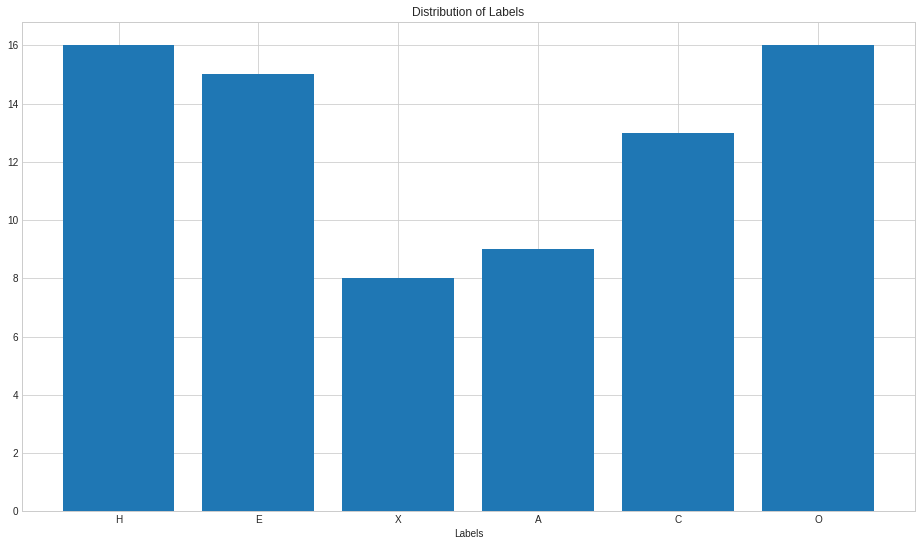

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

In [5]:
# count, _ = np.histogram(gt['label'], bins = 6)

# fig, ax = plt.subplots(figsize=(16,9))
# ax.bar(['H','E','X','A','C','O'],count)
# ax.set_title("Distribution of Labels")
# ax.set_xlabel("Labels")
# # ax.set_ylabel("Distribution of Labels")
# plt.show()

KeyError: 'label'

# Get Experiment DATA

In [19]:
path, folders, filenames = next(walk('./data'))
# Exclude these data because of incomplete data
gt.drop([11,4,36],inplace=True)

filenames.remove('11-audio.csv')
filenames.remove('11-image.csv')

filenames.remove('36-audio.csv')
filenames.remove('36-image.csv')

In [20]:
path = './data'
columns = {'Unnamed: 1':'Fp1',
        'Unnamed: 2':'Fp2',
        'Unnamed: 3':'F3',
        'Unnamed: 4':'F4',
        'Unnamed: 5':'F7',
        'Unnamed: 6':'F8',
        'Unnamed: 7':'P7',
        'Unnamed: 8':'P8'}

EEG_audio, EEG_image = dict(), dict()
from itertools import product
categories = [1,2,3,4,5]
blocks = [1,2]
for filename in tqdm(filenames):
    participant_id, stimuli = filename.split('-')
    stimuli = stimuli.rstrip('.csv')
    data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
    # print(participant_id, stimuli)
    # experiment = dict()
    # for (category, block) in product(categories,blocks):
        # print("   ", category, block)
        # section = get_section_from_catblock(data, category=category,block=block)
        # experiment[f"{category}_{block}"] = section
    if(stimuli == 'audio'):
        EEG_audio[int(participant_id)] = data
    elif(stimuli == 'image'):
        EEG_image[int(participant_id)] = data
    else:
        raise ValueError(f"Stimuli:{stimuli} is unexpected.")

  0%|          | 0/60 [00:00<?, ?it/s]

# New Ground Truth

In [21]:
gt

,h,e,x,a,c,o,lh,le,lx,la,lc,lo
id,,,,,,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,1,0,0,0,0,0
3,3.38,3.44,3.50,3.50,4.50,3.81,0,0,0,0,1,1
5,3.25,3.63,2.13,3.56,3.63,2.31,0,1,0,1,1,0
6,3.25,2.75,3.50,2.50,3.75,5.00,0,0,0,0,1,1
7,4.06,3.06,3.38,2.88,2.50,4.19,1,0,0,0,0,1
8,3.94,2.94,3.19,3.75,3.38,3.81,1,0,0,1,0,1
9,4.44,4.00,3.38,3.75,3.69,3.31,1,1,0,1,1,0
10,3.63,3.25,3.50,3.31,3.88,2.69,1,0,0,0,1,0
12,2.81,3.44,3.13,3.56,3.25,3.75,0,0,0,1,0,1


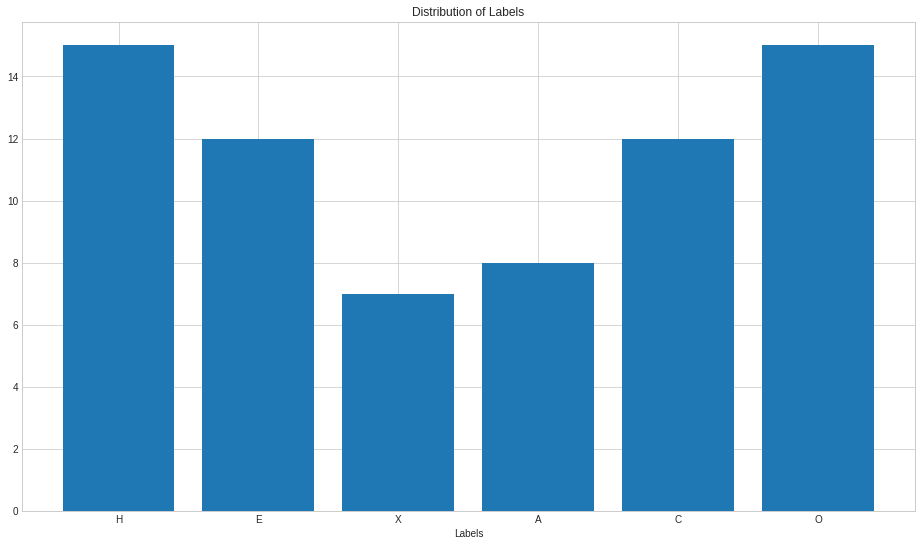

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

Extract for every image samples.

There are 

In [71]:
gt.loc[33][['lh','le','lx','la','lc','lo']]

lh    1.0
le    1.0
lx    0.0
la    1.0
lc    1.0
lo    0.0
Name: 33, dtype: float64

In [104]:
# Preprocess data + feature extraction using wavelet 'morlet'
def get_data_wt(eeg_type = 'image'):
    X = None
    # y = []
    Y = None
    participant_id = []
    categories = []
    # 'DELTA' 'THETA' 'ALPHA' 'BETA' 'Gamma'
    # https://reader.elsevier.com/reader/sd/pii/S0957417410005695?token=99F7CC487CECF9C17E36713347D0F8372A289AC2C6331A2B6C4F272CD34921FD8B418EB417C0F9C3796CEA271FB4455D&originRegion=eu-west-1&originCreation=20210510142445
    filter_list = np.array([4,8,13,30,125])
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in tqdm(ids):
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)

        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift

        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

        powers = tfr_morlet(epochs, freqs=filter_list, n_cycles=filter_list / 2., return_itc=False, average=False, verbose=False)
        features = np.mean(powers.data, axis=3)
        # print(features.shape) #(50,8,5)
        for e in range(features.shape[0]):
            row = np.expand_dims(features[e].reshape(-1), axis=0)
            row = 10 * np.log10(row)
            if(type(X) == type(None)): X = row
            else: X = np.concatenate( [X, row ], axis=0 )
            # y.append(gt.loc[id]['label'])

            label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
            label = np.expand_dims(label, axis=0)
            if(type(Y) == type(None)): Y = label
            else: Y = np.concatenate( [Y, label ], axis=0 )
            participant_id.append(id)
        for e in events[:,2]:
            categories.append(str(e)[0])
            # print(Y.shape)
    # y = np.array(y)
    return X,Y,np.array(participant_id),np.array(categories)

# Save everything into CSV file

In [105]:
import warnings
warnings.filterwarnings("ignore")

channels = list(columns.values())
band_name = np.array(['DELTA','THETA','ALPHA','BETA','Gamma'])
X_head = dict()
count = 0
for channel in channels:
    for band in band_name:
        X_head[count] = (f"{channel}-{band}")
        count += 1
print(X_head)

{0: 'Fp1-DELTA', 1: 'Fp1-THETA', 2: 'Fp1-ALPHA', 3: 'Fp1-BETA', 4: 'Fp1-Gamma', 5: 'Fp2-DELTA', 6: 'Fp2-THETA', 7: 'Fp2-ALPHA', 8: 'Fp2-BETA', 9: 'Fp2-Gamma', 10: 'F3-DELTA', 11: 'F3-THETA', 12: 'F3-ALPHA', 13: 'F3-BETA', 14: 'F3-Gamma', 15: 'F4-DELTA', 16: 'F4-THETA', 17: 'F4-ALPHA', 18: 'F4-BETA', 19: 'F4-Gamma', 20: 'F7-DELTA', 21: 'F7-THETA', 22: 'F7-ALPHA', 23: 'F7-BETA', 24: 'F7-Gamma', 25: 'F8-DELTA', 26: 'F8-THETA', 27: 'F8-ALPHA', 28: 'F8-BETA', 29: 'F8-Gamma', 30: 'P7-DELTA', 31: 'P7-THETA', 32: 'P7-ALPHA', 33: 'P7-BETA', 34: 'P7-Gamma', 35: 'P8-DELTA', 36: 'P8-THETA', 37: 'P8-ALPHA', 38: 'P8-BETA', 39: 'P8-Gamma'}


In [106]:
for eeg_type in ['image','audio']:
    X,Y,participant_id,categories = get_data_wt(eeg_type)
    df = pd.DataFrame(X).rename(columns=X_head)
    df['id'] = participant_id
    df['category'] = categories
    df['label_h'] = Y[:,0]
    df['label_e'] = Y[:,1]
    df['label_x'] = Y[:,2]
    df['label_a'] = Y[:,3]
    df['label_c'] = Y[:,4]
    df['label_o'] = Y[:,5]
    df.to_csv(f'./data_process/{eeg_type}.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

# load data from the prepared file

In [1]:
import pandas
image_df = pandas.read_csv('./data_process_wt/image.csv').rename(columns={'Unnamed: 0':'sample'}).set_index('sample')
audio_df = pandas.read_csv('./data_process_wt/audio.csv').rename(columns={'Unnamed: 0':'sample'}).set_index('sample')

In [2]:
image_df

,Fp1-DELTA,Fp1-THETA,Fp1-ALPHA,Fp1-BETA,Fp1-Gamma,Fp2-DELTA,Fp2-THETA,Fp2-ALPHA,Fp2-BETA,Fp2-Gamma,...,P8-BETA,P8-Gamma,id,category,label_h,label_e,label_x,label_a,label_c,label_o
sample,,,,,,,,,,,,,,,,,,,,,
0,-85.891826,-91.047487,-95.653502,-101.947011,-116.121450,-85.517711,-90.903300,-96.054843,-104.037273,-116.897175,...,-102.902723,-116.464358,2,3,1.0,0.0,0.0,0.0,0.0,0.0
1,-71.314941,-86.290477,-97.064894,-101.975869,-115.996640,-70.779193,-85.975520,-97.353817,-101.025682,-115.126521,...,-103.723203,-115.543537,2,3,1.0,0.0,0.0,0.0,0.0,0.0
2,-81.833357,-89.067981,-93.367385,-99.836433,-116.864162,-83.202379,-90.072051,-93.890308,-100.337242,-116.596184,...,-103.592066,-115.044039,2,3,1.0,0.0,0.0,0.0,0.0,0.0
3,-77.955412,-87.433110,-94.570667,-101.809428,-117.477577,-76.622928,-87.049639,-95.019470,-103.752182,-117.594181,...,-102.495543,-118.340041,2,3,1.0,0.0,0.0,0.0,0.0,0.0
4,-79.834620,-89.757235,-96.566699,-100.341410,-116.289318,-78.845457,-88.976123,-96.630474,-101.173557,-116.774309,...,-102.498649,-117.918371,2,3,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-80.135240,-87.981819,-91.725794,-97.528959,-112.186684,-81.215697,-89.558893,-91.460350,-104.308271,-117.867852,...,-101.369868,-115.562186,35,2,1.0,0.0,1.0,1.0,0.0,1.0
1496,-80.886613,-88.068374,-90.530288,-99.212831,-109.182121,-81.649877,-88.253124,-90.209006,-102.572319,-111.968517,...,-100.695221,-111.514913,35,2,1.0,0.0,1.0,1.0,0.0,1.0
1497,-79.909576,-88.417450,-89.959118,-99.633077,-110.497021,-81.112093,-88.294101,-90.795258,-104.817580,-114.066408,...,-100.324670,-112.377828,35,2,1.0,0.0,1.0,1.0,0.0,1.0


In [3]:
audio_df

,Fp1-DELTA,Fp1-THETA,Fp1-ALPHA,Fp1-BETA,Fp1-Gamma,Fp2-DELTA,Fp2-THETA,Fp2-ALPHA,Fp2-BETA,Fp2-Gamma,...,P8-BETA,P8-Gamma,id,category,label_h,label_e,label_x,label_a,label_c,label_o
sample,,,,,,,,,,,,,,,,,,,,,
0,-68.235167,-82.122621,-96.597092,-102.013609,-114.813873,-68.128066,-82.290346,-96.870818,-102.378628,-115.951858,...,-103.044246,-116.386129,2,3,1.0,0.0,0.0,0.0,0.0,0.0
1,-71.657584,-85.963182,-96.308071,-100.526182,-115.194507,-71.470229,-86.124459,-96.716043,-99.435186,-114.375143,...,-102.681549,-114.843413,2,3,1.0,0.0,0.0,0.0,0.0,0.0
2,-70.767382,-85.627485,-97.259239,-101.253665,-118.083340,-70.638663,-85.660762,-97.589809,-101.477298,-117.996739,...,-102.504333,-118.155557,2,3,1.0,0.0,0.0,0.0,0.0,0.0
3,-69.539953,-83.989113,-88.981993,-96.061448,-107.226573,-69.427370,-83.559591,-89.051818,-96.688703,-106.708663,...,-102.866476,-117.463050,2,3,1.0,0.0,0.0,0.0,0.0,0.0
4,-71.377770,-86.423616,-95.472494,-100.316545,-114.043521,-71.081387,-86.316232,-96.910931,-102.661582,-114.383537,...,-104.046597,-114.925184,2,3,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-85.924100,-81.833483,-88.748889,-100.963264,-115.665023,-85.030621,-81.107454,-88.327544,-104.627055,-117.806662,...,-99.853901,-115.788257,35,2,1.0,0.0,1.0,1.0,0.0,1.0
1496,-81.590355,-83.579534,-88.205236,-98.843433,-111.839547,-82.707204,-84.044878,-88.472483,-104.332866,-117.676812,...,-99.604320,-112.257754,35,2,1.0,0.0,1.0,1.0,0.0,1.0
1497,-83.631729,-83.904275,-88.595344,-99.079324,-111.238276,-84.083720,-84.317510,-89.046140,-103.452220,-114.680554,...,-100.286299,-113.506551,35,2,1.0,0.0,1.0,1.0,0.0,1.0


# Build image - H predictor

In [4]:
''' For experiment '''
# from sklearn.naive_bayes import MultinomialNB as model
# from sklearn.model_selection import cross_val_score
# # from sklearn.naive_bayes import GaussianNB as model
# from sklearn.preprocessing import normalize, StandardScaler
# X_copy = X.copy()
# # X_norm = normalize(X_copy, axis=1)*-1
# # X_norm = StandardScaler().fit_transform(X_norm) + 100
# X_norm = X_copy*-1
# clf = model()
# clf.fit(X_norm, y)
# print(sum(clf.predict(X_norm) == y) / len(y))
# scores = cross_val_score(clf, X_norm, y, cv = 5)
# print("Multinomial NB Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

' For experiment '

In [5]:
from sklearn.naive_bayes import MultinomialNB as model
# from sklearn.naive_bayes import GaussianNB as model
from sklearn.model_selection import cross_val_score
import pickle
X_head = {0: 'Fp1-DELTA', 1: 'Fp1-THETA', 2: 'Fp1-ALPHA', 3: 'Fp1-BETA', 4: 'Fp1-Gamma', 5: 'Fp2-DELTA', 6: 'Fp2-THETA', 7: 'Fp2-ALPHA', 8: 'Fp2-BETA', 9: 'Fp2-Gamma', 10: 'F3-DELTA', 11: 'F3-THETA', 12: 'F3-ALPHA', 13: 'F3-BETA', 14: 'F3-Gamma', 15: 'F4-DELTA', 16: 'F4-THETA', 17: 'F4-ALPHA', 18: 'F4-BETA', 19: 'F4-Gamma', 20: 'F7-DELTA', 21: 'F7-THETA', 22: 'F7-ALPHA', 23: 'F7-BETA', 24: 'F7-Gamma', 25: 'F8-DELTA', 26: 'F8-THETA', 27: 'F8-ALPHA', 28: 'F8-BETA', 29: 'F8-Gamma', 30: 'P7-DELTA', 31: 'P7-THETA', 32: 'P7-ALPHA', 33: 'P7-BETA', 34: 'P7-Gamma', 35: 'P8-DELTA', 36: 'P8-THETA', 37: 'P8-ALPHA', 38: 'P8-BETA', 39: 'P8-Gamma'}

In [16]:
image_predictor = dict()
image_pred = dict()
for label in ['label_h','label_e','label_x','label_a','label_c','label_o']:
    X = image_df[list(X_head.values())]
    y = image_df[label]
    X_copy = X.copy() * -1
    clf = model()
    clf.fit(X_copy, y)
    acc = sum(clf.predict(X_copy) == y) / len(y)
    # clf.predict_proba(X_copy)[0]
    image_pred[label] = clf.predict_proba(X_copy)[:,0]
    scores_image = cross_val_score(clf, X_copy, y)
    image_predictor[label] = clf
    print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores_image.mean(), scores_image.std() * 2))

with open('models/image_predictor.pickle', 'wb') as handle:
    pickle.dump(image_predictor, handle, protocol=pickle.HIGHEST_PROTOCOL)

label_h | Accuracy: 0.69 Scores: 0.33 (+/- 0.17)
label_e | Accuracy: 0.64 Scores: 0.59 (+/- 0.03)
label_x | Accuracy: 0.77 Scores: 0.77 (+/- 0.00)
label_a | Accuracy: 0.73 Scores: 0.72 (+/- 0.05)
label_c | Accuracy: 0.68 Scores: 0.63 (+/- 0.11)
label_o | Accuracy: 0.68 Scores: 0.32 (+/- 0.19)


In [8]:
audio_predictor = dict()
for label in ['label_h','label_e','label_x','label_a','label_c','label_o']:
    X = audio_df[list(X_head.values())]
    y = audio_df[label]
    X_copy = X.copy() * -1
    clf = model()
    clf.fit(X_copy, y)
    acc = sum(clf.predict(X_copy) == y) / len(y)
    scores_audio = cross_val_score(clf, X_copy, y)
    audio_predictor[label] = clf
    print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores_audio.mean(), scores_audio.std() * 2))

with open('models/audio_predictor.pickle', 'wb') as handle:
    pickle.dump(audio_predictor, handle, protocol=pickle.HIGHEST_PROTOCOL)

label_h | Accuracy: 0.64 Scores: 0.35 (+/- 0.29)
label_e | Accuracy: 0.63 Scores: 0.56 (+/- 0.10)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.74 Scores: 0.67 (+/- 0.18)
label_c | Accuracy: 0.69 Scores: 0.63 (+/- 0.16)
label_o | Accuracy: 0.63 Scores: 0.59 (+/- 0.08)
